In [1]:
import numpy as np
set1 = np.arange(0,9)
set2 = np.arange(9,18)
set3 = np.arange(18,27)
set4 = np.arange(27,36)
set5 = np.arange(36,45)

from scenes import scene_locations1, scene_locations2, scene_locations3

folder_path = '/home/bjangley/VPR/VPRMethods/final_mast3r_test_dataset' # path folder storing the images
metadata_file = '/home/bjangley/VPR/VPRMethods/final_mast3r_test_dataset/metadata.csv' #path to metadata file

master_size = [512,384] #size of image used by mast3r



#imports for visualizing matches
import numpy as np

from matplotlib import pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2 #for pnp
from pyproj import Proj, transform #cartographic transformations and coordinate conversions

#supressing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import os
from PIL import Image


#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"


from utils import (
    getMasterOutout,
    scale_intrinsics,
    CameraMatrix,
    run_pnp,
    getImageFromIndex,
)




## Display Scene

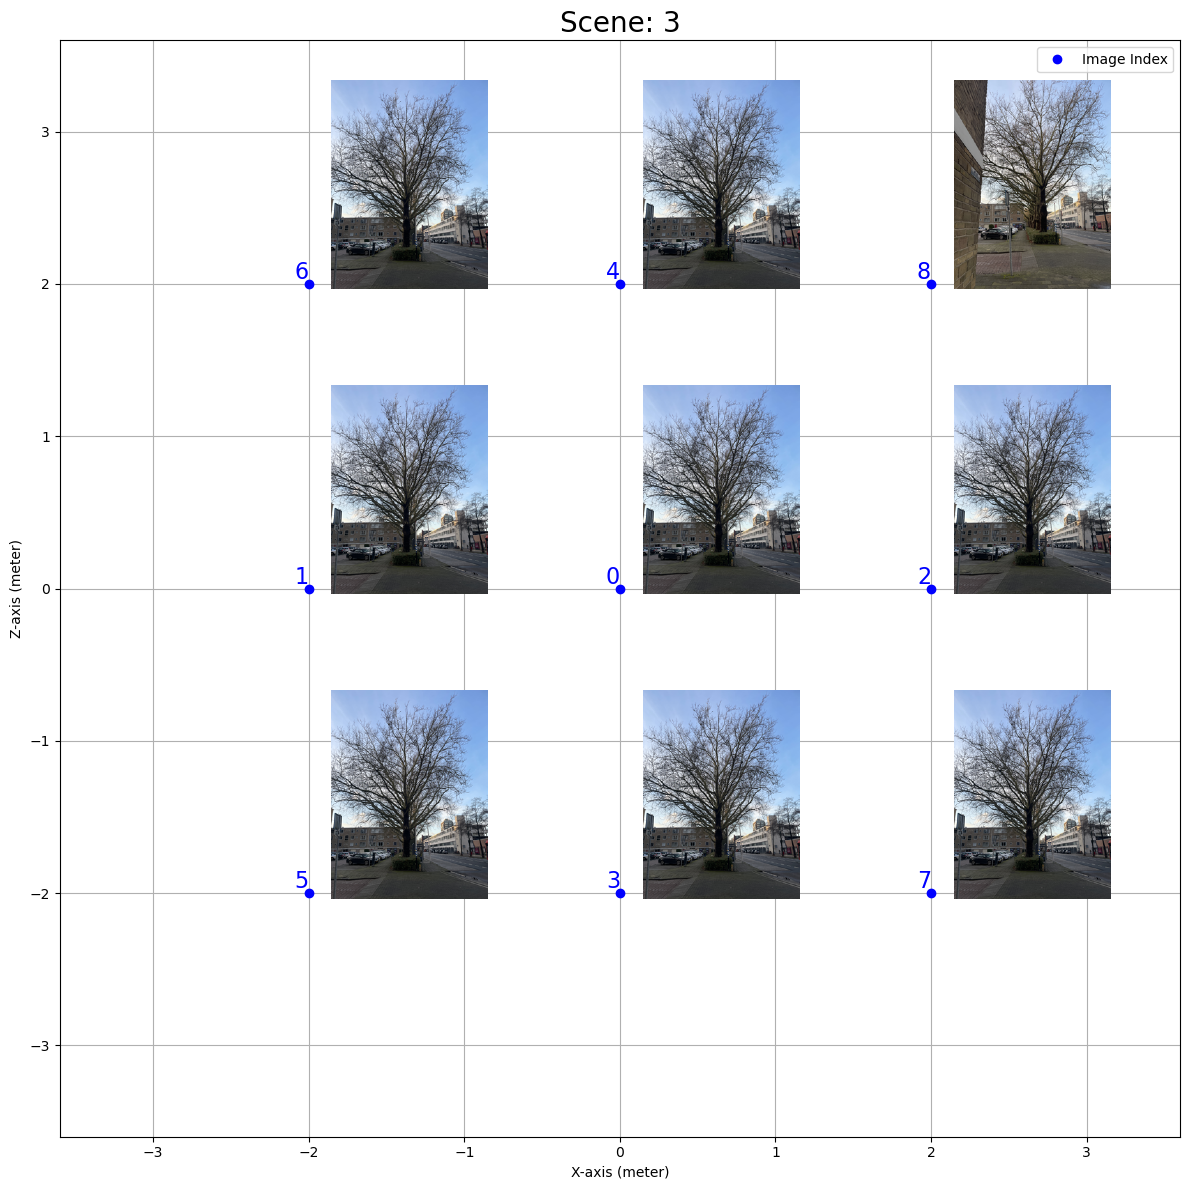

In [43]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def displayScene(scene_locations, corrected_data, set_number, folder_path):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Calculate the bounding box of the scene
    x_coords = [loc[0]/100 for loc in scene_locations]
    y_coords = [loc[1]/100 for loc in scene_locations]
    x_min, x_max = min(x_coords)-1, max(x_coords)+1
    y_min, y_max = min(y_coords)-1, max(y_coords)+1
    
    # Add some padding
    padding = 0.1 * max(x_max - x_min, y_max - y_min)
    x_min, y_min = x_min - padding, y_min - padding
    x_max, y_max = x_max + padding, y_max + padding

    for i, location in enumerate(scene_locations):
        x, y = location[0]/100, location[1]/100
        ax.plot(x, y, 'o', color='blue', label='Image Index' if i==0 else '')
        ax.text(x, y, str(i), color='blue', fontsize=16, ha='right', va='bottom')
        
        anchor_image_dict, anchor_image_path_og = getImageFromIndex(corrected_data[i][0], folder_path)
        
        # Open the image and create a copy to avoid modifying the original
        img = Image.open(anchor_image_path_og).rotate(-90,expand=True).copy() #
        
        # Calculate the aspect ratio
        aspect_ratio = img.width / img.height
        
        # Set the maximum dimension
        max_dim = 300
        
        # Calculate new dimensions while maintaining aspect ratio
        if img.width > img.height:
            new_width = max_dim
            new_height = int(max_dim / aspect_ratio)
        else:
            new_height = max_dim
            new_width = int(max_dim * aspect_ratio)
        
        # Resize the image while maintaining aspect ratio
        img.thumbnail((new_width, new_height), Image.LANCZOS)
        
        # Offset the image slightly
        offset_x = 0.09 * (x_max - x_min)
        offset_y = 0.09 * (y_max - y_min)
        
        im = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(im, (x + offset_x, y + offset_y), xycoords='data', frameon=False)
        ax.add_artist(ab)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis (meter)')
    ax.set_ylabel('Z-axis (meter)')
    ax.set_title(f'Scene: {set_number}', fontsize=20)
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function
corrected_data = np.load("results/scene3.npy", allow_pickle=True)
# displayScene(scene_locations3, corrected_data, 3, folder_path)


# Master Inference On Two Images 

>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.7269 seconds.
Point Matches Time: 0.3308 seconds.
Number of matches before confidence mask:  2478


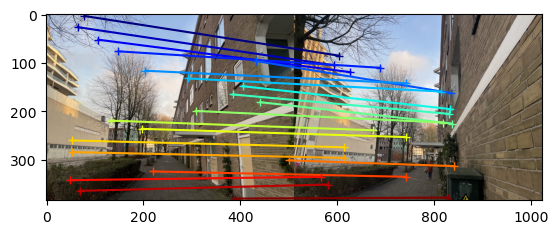

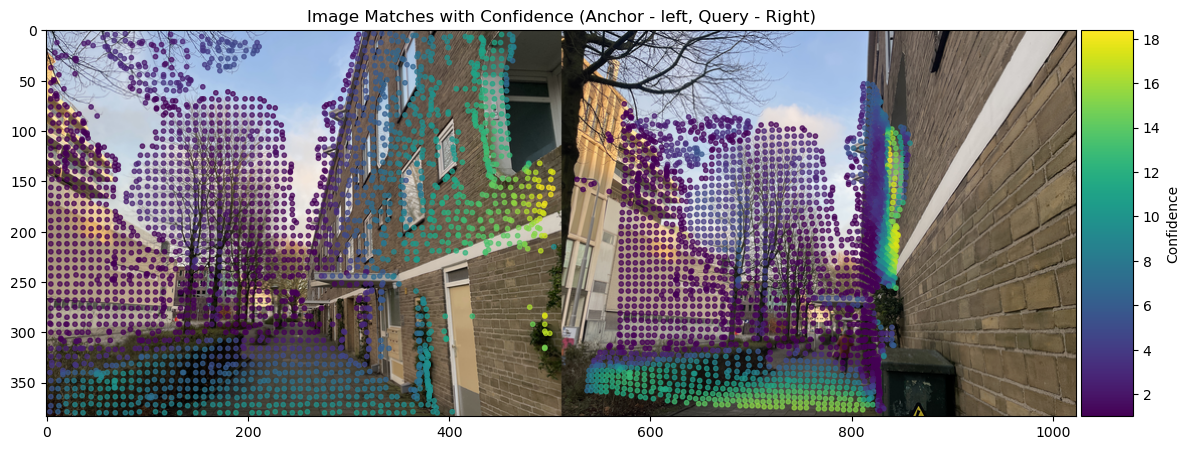

Number of matches after confidence mask:  911
Lowest Confidence Value:  6.9726396 3.094988


/home/bjangley/VPR/mast3r/utils.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


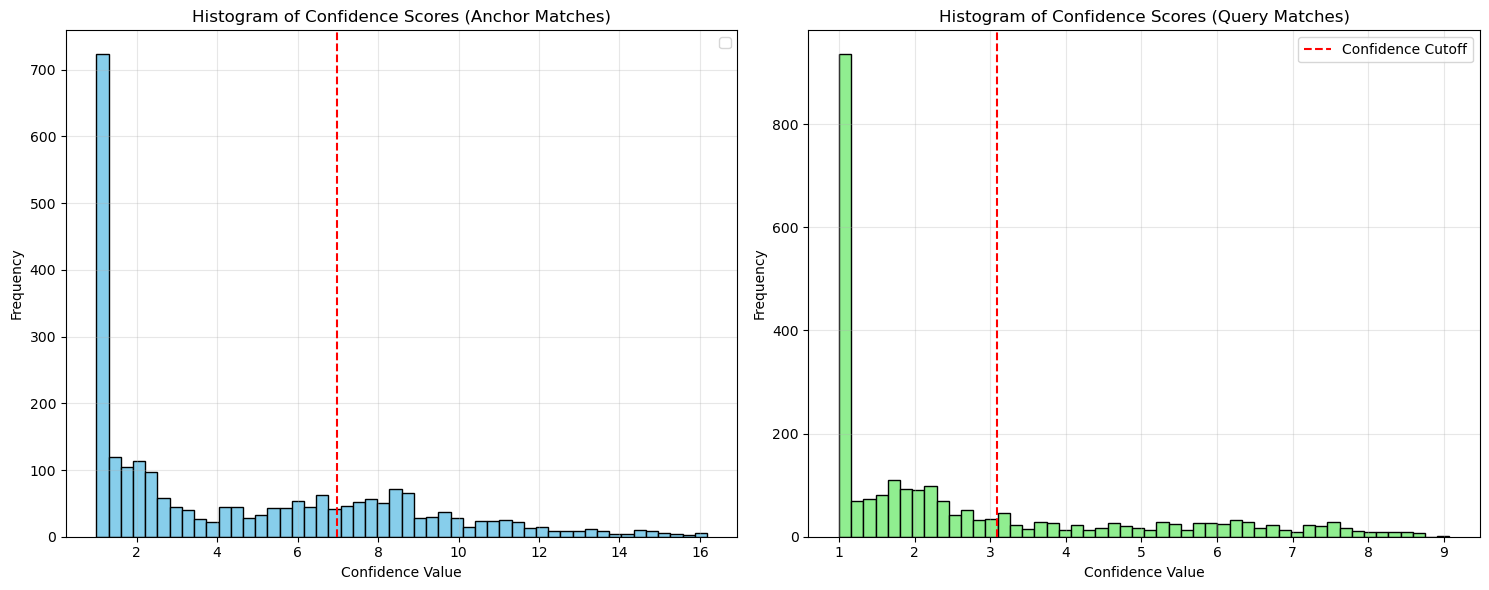

Predicted Transform:
 [ 0.78013209 -0.09665644 -0.46621008] [[ 0.99246256 -0.02301147 -0.12036836  0.78013209]
 [ 0.01395431  0.99704407 -0.07555402 -0.09665644]
 [ 0.12175117  0.07330487  0.98985001 -0.46621008]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 0.9088222682644714


In [2]:
#input
scene = set5
n_matches = 700
anchor= 0
query = 6



corrected_data=[]

anchor_index = scene[anchor] #get image index in metedatafile
anchor_image_dict, anchor_image_path_og = getImageFromIndex(anchor_index, folder_path)
anchor_image = Image.open(anchor_image_path_og)
anchor_image = anchor_image#.rotate(-90, expand=True)
anchor_image_size = anchor_image.size  #original size of image

query_index = scene[query]
query_image_dict, query_image_path_og = getImageFromIndex(query_index,folder_path)
query_image = Image.open(query_image_path_og)
query_image = query_image#.rotate(-90, expand=True)

anchor_image_path = '/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
query_image_path = '/home/bjangley/VPR/mast3r/sanity_check/query.png'
anchor_image.save(anchor_image_path, format='PNG')
query_image.save(query_image_path, format='PNG')

K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243) #landscape
K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[0],master_size[1])

# K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) #portrait
# K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[1],master_size[0])

filtered_matches_im0,filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches,visualizeMatches=True)

# Predicted Transform copied from visloc.py
ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :].astype(np.float32), K_scaled.astype(np.float32))

if ret_val: 

    pnp_rotation = transformation[:3, :3]  
    pnp_translation = transformation[:3, 3]  
    print("Predicted Transform:\n", pnp_translation, transformation)    
    # Calculate and print the magnitude of the translation
    translation_magnitude = np.linalg.norm([pnp_translation[0],pnp_translation[2]])
    print("Translation Magnitude:", translation_magnitude)
    corrected_data.append([anchor,query,pnp_translation])

In [11]:
import plotly.graph_objects as go




def create_3d_plot(pts3d, matches,conf, threshold=3):
    fig = go.Figure()
    
    X = pts3d[conf > threshold]

    # Add all points from image 0
    fig.add_trace(go.Scatter3d(
        x=X[:, 0].flatten(),
        y=X[:, 1].flatten(),
        z=X[:, 2].flatten(),
        mode='markers',
        marker=dict(size=1, color='blue', opacity=0.2),
        name='Image 0 Points'
    ))


    # Add matched points from image 0
    matched = pts3d[matches[:, 1], matches[:, 0]]
    matched_conf = conf[matches[:, 1], matches[:, 0]]
    normalized_conf = (matched_conf - matched_conf.min()) / (matched_conf.max() - matched_conf.min())
    print(normalized_conf.max(),normalized_conf.min())
    fig.add_trace(go.Scatter3d(
        x=matched[:, 0],
        y=matched[:, 1],
        z=matched[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=normalized_conf,
            colorscale='sunsetdark',
            # opacity=0.8
        ),
        name='Matched Points (Image 0)'
    ))


    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Matched Points'
    )

    fig.show()


#create_3d_plot(pts3d_im0, matches_im0, conf_im0)
#create_3d_plot(pts3d_im1, matches_im1, conf_im1,threshold=3)


def apply_transformation(points, rotation, translation):
    return np.dot(points, rotation.T) + translation

def create_3d_plot_comparison(pts3d_im0, pts3d_im1, conf_im0, conf_im1, transformation, threshold=3):
    # Filter points based on confidence
    filtered_pts3d_im0 = pts3d_im0[conf_im0 > threshold]
    filtered_pts3d_im1 = pts3d_im1[conf_im1 > threshold]

    # Apply transformation to filtered_pts3d_im0
    rotation = transformation[:3, :3]
    translation = transformation[:3, 3]
    transformed_pts3d_im0 = apply_transformation(filtered_pts3d_im0, rotation, translation)

    fig = go.Figure()

    # Add transformed points from image 0
    fig.add_trace(go.Scatter3d(
        x=transformed_pts3d_im0[:, 0],
        y=transformed_pts3d_im0[:, 1],
        z=transformed_pts3d_im0[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue', opacity=0.5),
        name='Transformed Image 0 Points'
    ))

    # Add points from image 1
    fig.add_trace(go.Scatter3d(
        x=filtered_pts3d_im1[:, 0],
        y=filtered_pts3d_im1[:, 1],
        z=filtered_pts3d_im1[:, 2],
        mode='markers',
        marker=dict(size=2, color='red', opacity=0.5),
        name='Image 1 Points'
    ))

        # Add points from image 1
    fig.add_trace(go.Scatter3d(
        x=filtered_pts3d_im0[:, 0],
        y=filtered_pts3d_im0[:, 1],
        z=filtered_pts3d_im0[:, 2],
        mode='markers',
        marker=dict(size=2, color='green', opacity=0.5),
        name='Image 1 Points'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Comparison of Transformed Image 0 and Image 1 Point Clouds'
    )

    fig.show()

# Use the function
#create_3d_plot_comparison(pts3d_im0, pts3d_im1, conf_im0, conf_im1, transformation, threshold=3)



points_3d_master = pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :]

depth = 1.0
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]

# Create an array for estimated 3D points
points_3d_estimated = np.zeros((filtered_matches_im1.shape[0], 3))

# Calculate the estimated 3D points based on the intrinsic matrix
for i in range(filtered_matches_im1.shape[0]):
    u, v = filtered_matches_im1[i]
    # Convert pixel coordinates to camera coordinates
    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth
    points_3d_estimated[i] = [x, y, z]

# Calculate the inverse transformation
inverse_transform = np.linalg.inv(transformation)

# Extract rotation and translation from the inverse transformation matrix
inverse_rotation = inverse_transform[:3, :3]
inverse_translation = inverse_transform[:3, 3]
    
# Apply rotation and translation to the scaled estimated points
points_3d_estimated_transformed = np.dot(points_3d_estimated, inverse_rotation.T) + inverse_translation

# Calculate distances from centroids
distances_estimated = np.sqrt(np.sum((points_3d_estimated_transformed[:, :2] )**2, axis=1))
distances_master = np.sqrt(np.sum((points_3d_master[:, :2])**2, axis=1))

print(np.mean(distances_estimated),np.mean(distances_master))
# Calculate ratios
ratios = distances_master / distances_estimated

# Use median ratio as scale factor (more robust to outliers than mean)
scale_factor = np.median(ratios)

print(f"Estimated scale factor: {scale_factor}")

print(points_3d_estimated_transformed[0], points_3d_master[0])

# Apply scale factor to estimated points
points_3d_estimated_scaled = points_3d_estimated_transformed *scale_factor





1.2553543017834652 1.3353002
Estimated scale factor: 1.0261040169432027
[-1.21842756 -0.29696805  1.65310324] [ 0.91668826 -2.506499    5.2246695 ]


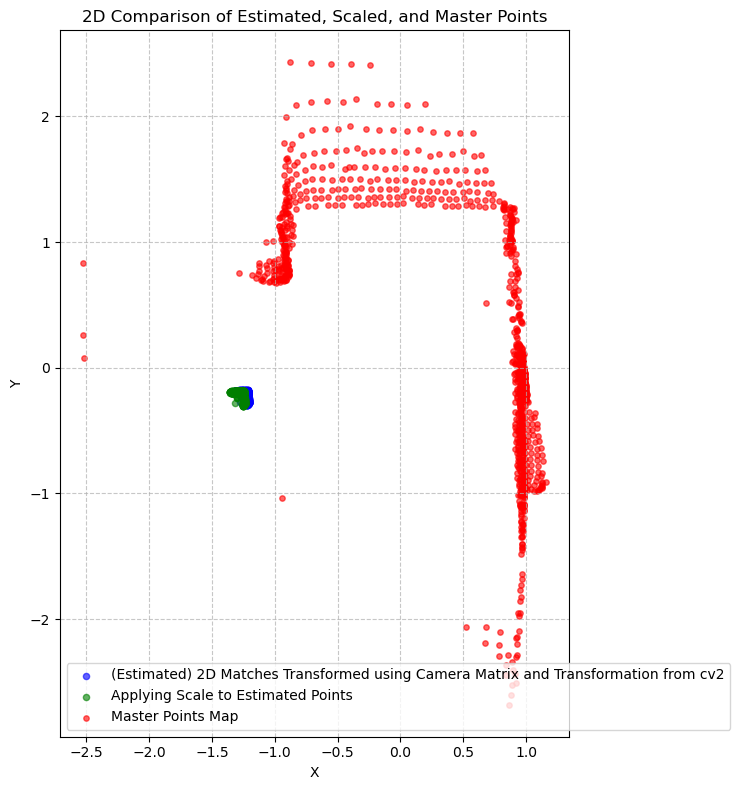

In [12]:



# Create the figure
fig = go.Figure()

# Add estimated points (projected)
fig.add_trace(go.Scatter3d(
    x=points_3d_estimated[:, 0],
    y=points_3d_estimated[:, 1],
    z=points_3d_estimated[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.8
    ),
    name='Estimated Points'
))

# Add estimated points (projected)
fig.add_trace(go.Scatter3d(
    x=points_3d_estimated_scaled[:, 0],
    y=points_3d_estimated_scaled[:, 1],
    z=0*points_3d_estimated_scaled[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='green',
        opacity=0.8
    ),
    name='Estimated Points'
))

# Add master points (actual 3D points)
fig.add_trace(go.Scatter3d(
    x=points_3d_master[:, 0],
    y=points_3d_master[:, 1],
    z=points_3d_master[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Master Points (Actual)'
))

# Update layout
fig.update_layout(
    title='Comparison of Estimated and Master 3D Points',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend=dict(x=0.7, y=0.9),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()



# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot estimated points (blue)
ax.scatter(points_3d_estimated_transformed[:, 0], points_3d_estimated_transformed[:, 1], 
           color='blue', s=20, alpha=0.6, label='(Estimated) 2D Matches Transformed using Camera Matrix and Transformation from cv2')

# Plot scaled estimated points (green)
ax.scatter(points_3d_estimated_scaled[:, 0], points_3d_estimated_scaled[:, 1], 
           color='green', s=20, alpha=0.6, label='Applying Scale to Estimated Points')

# Plot master points (red)
ax.scatter(points_3d_master[:, 0], points_3d_master[:, 1], 
           color='red', s=15, alpha=0.6, label='Master Points Map')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Comparison of Estimated, Scaled, and Master Points')

# Add legend
ax.legend()

# Ensure equal aspect ratio
ax.set_aspect('equal', 'box')

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


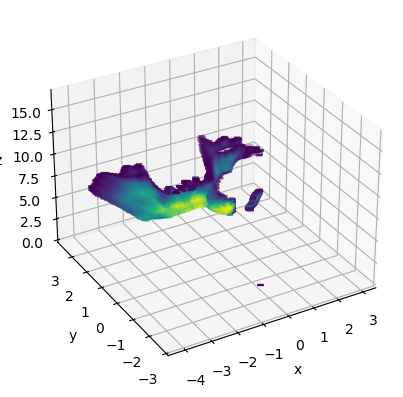

In [5]:

Ct = 3
X = pts3d_im1[conf_im1 > Ct]
C = conf_im1[conf_im1 > Ct]

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=C, marker=1)
ax.grid('on')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-120, roll=0)

>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.2142 seconds.
Point Matches Time: 0.1439 seconds.
Number of matches after confidence mask:  14
Lowest Confidence Value:  15.848593 10.650375
Predicted Transform:
 [ 0.82275046 -0.05373909  0.20157805]
Translation Magnitude: 0.8470844273995446
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Mast3r Inference Time: 0.2069 seconds.
Point Matches Time: 0.1562 seconds.
Number of matches after confidence mask:  14
Lowest Confidence Value:  12.475053 12.698451
Predicted Transform:
 [-0.65027115  0.00326211 -0.02811917]
Translation Magnitud

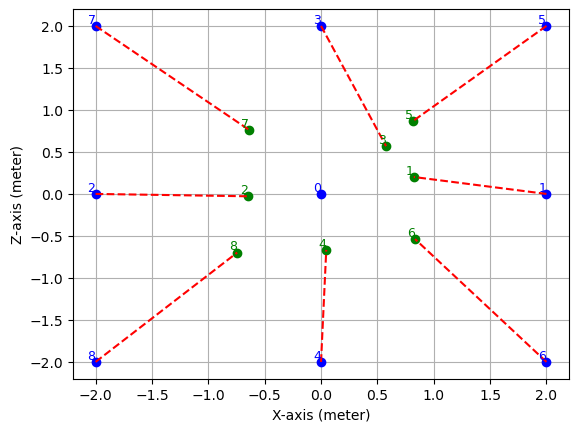

In [26]:
scene = set5
scene_locations = scene_locations2
n_matches = 10
anchor = 0
anchor_index = scene[anchor]


corrected_data=[]

anchor_image_dict, anchor_image_path_og = getImageFromIndex(anchor_index, folder_path)
anchor_image = Image.open(anchor_image_path_og)
# anchor_image = anchor_image.rotate(-90, expand=True)
anchor_image_size = anchor_image.size  #original size of image
anchor_image_path = '/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
query_image_path = '/home/bjangley/VPR/mast3r/sanity_check/query.png'
anchor_image.save(anchor_image_path, format='PNG')

for query_index in scene:
    if query_index != anchor_index: 
        query_image_dict, query_image_path_og = getImageFromIndex(query_index,folder_path)
        query_image = Image.open(query_image_path_og)
        # query_image = query_image.rotate(-90, expand=True)
        query_image.save(query_image_path, format='PNG')

        K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243) #landscape
        K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[0],master_size[1])

        # K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) #portrait
        # K_scaled = scale_intrinsics(K,anchor_image_size[0], anchor_image_size[1],master_size[1],master_size[0])

        filtered_matches_im0, filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches,visualizeMatches=False)

        # Predicted Transform copied from visloc.py
        ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :], K_scaled.astype(np.float32))

        if ret_val: 
            pnp_rotation = transformation[:3, :3]  
            pnp_translation = transformation[:3, 3]  
            print("Predicted Transform:\n", pnp_translation)    
            # Calculate and print the magnitude of the translation
            translation_magnitude = np.linalg.norm([pnp_translation[0],pnp_translation[2]])
            print("Translation Magnitude:", translation_magnitude)
            corrected_data.append([anchor_index,query_index,pnp_translation])



plt.figure()

# Plot and label scene_locations points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[2][0], location[2][2], 'o', color='green')
    plt.text(location[2][0], location[2][2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')

# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][2][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()

In [20]:
print(anchor_image_size)

(4032, 3024)


## Mast3r Inference on Entire Scene (every image with every other image)

In [7]:

scene = set1
n_matches = 30


corrected_data = []

for anchor_index in scene:
    anchor_image_dict, anchor_image_path_og = getImageFromIndex(anchor_index, folder_path)
    anchor_image = Image.open(anchor_image_path_og).rotate(-90, expand=True)
    anchor_image_size = anchor_image.size
    anchor_image_path = f'/home/bjangley/VPR/mast3r/sanity_check/anchor.png'
    anchor_image.save(anchor_image_path, format='PNG')
    for query_index in scene:
        if anchor_index != query_index:  # Skip comparing an image with itself
            query_image_dict, query_image_path_og = getImageFromIndex(query_index, folder_path)
            # Process images
            query_image = Image.open(query_image_path_og).rotate(-90, expand=True)
            query_image_path = f'/home/bjangley/VPR/mast3r/sanity_check/query.png'
            query_image.save(query_image_path, format='PNG')
            
            # Camera matrix and scaling
            K = CameraMatrix(2744.8442, 2744.8442, 1521.5243, 2014.26)
            K_scaled = scale_intrinsics(K, anchor_image_size[0], anchor_image_size[1], master_size[1], master_size[0])
            
            # Get matches and run PnP
            filtered_matches_im0, filtered_matches_im1,matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(anchor_image_path, query_image_path, n_matches, visualizeMatches=False)
            ret_val, transformation = run_pnp(filtered_matches_im1.astype(np.float32), pts3d_im0[filtered_matches_im0[:, 1], filtered_matches_im0[:, 0], :], K_scaled.astype(np.float32))
            print(transformation)
            if ret_val:
                pnp_translation = transformation[:3, 3]
                corrected_data.append([anchor_index, query_index, pnp_translation])


"Save data (if required)"
# output = np.array(corrected_data, dtype=object)
# np.save("results/scene1.npy", output, allow_pickle=True)

"Load Data"
# corrected_data = np.load("results/scene1.npy", allow_pickle=True)




>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Mast3r Inference Time: 0.2035 seconds.
Point Matches Time: 0.1114 seconds.
Number of matches after confidence mask:  47
Lowest Confidence Value:  7.5254536 6.6933355
[[ 0.99956235 -0.02462951 -0.01638591  0.10187132]
 [ 0.02283966  0.99455699 -0.10165993 -0.14641194]
 [ 0.01880055  0.10124119  0.99468425 -1.03362863]
 [ 0.          0.          0.          1.        ]]
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/anchor.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/query.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Mast3r Inference Time: 0.2050 seconds.
Point Matches Time: 0.0868 seconds.
Number of matches after confidence mask:  38
Lowest Confidence Value

'Load Data'

In [105]:
scene_locations = scene_locations2
set_images = set5
scene_number = 5
corrected_data = np.load('results/scene5.npy',allow_pickle=True)

import ipywidgets as widgets
from IPython.display import display

def update_plot(anchor):
    plt.figure(figsize=(8, 6))
    
    # Plot original scene locations
    for i, location in enumerate(scene_locations):
        plt.plot(location[0]/100, location[1]/100, 'o', color='blue')#, label='Original' if i == 0 else ''
        plt.text(location[0]/100, location[1]/100, str(i), color='blue', fontsize=9, ha='right', va='bottom')
    
            
    for x in corrected_data: #counter, object
        if x[0] == set_images[anchor]:
            anchor = np.where(set_images==x[0])[0][0]
            query = np.where(set_images==x[1])[0][0]
            new_location = [scene_locations[anchor][0]/100 + scale_factor*x[2][0] ,scene_locations[anchor][1]/100+ scale_factor*x[2][2]] 
            plt.plot(new_location[0], new_location[1], 'o', color='green')
            plt.text(new_location[0], new_location[1], f'{anchor}->{query}', color='green', fontsize=9, ha='left', va='bottom')
            plt.plot([scene_locations[query][0]/100, new_location[0]], 
                    [scene_locations[query][1]/100, new_location[1]], 'r--', alpha=0.5)
        
    plt.xlabel('X-axis (meter)')
    plt.ylabel('Z-axis (meter)')
    plt.title(f'Anchor: {set1[anchor]}')
    plt.grid(True)

    # Save the figure
    # filename = os.path.join('results/plots', f'scene_{scene_number}_anchor_{anchor}.png')
    # plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

# Create a slider widget for anchor selection
anchor_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(set_images) - 1,
    step=1,
    description='Anchor:',
    continuous_update=False
)

# Display the widget and update the plot when the anchor changes
# display(anchor_slider)
widgets.interactive(update_plot, anchor=anchor_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Anchor:', max=8), Output()), _d…

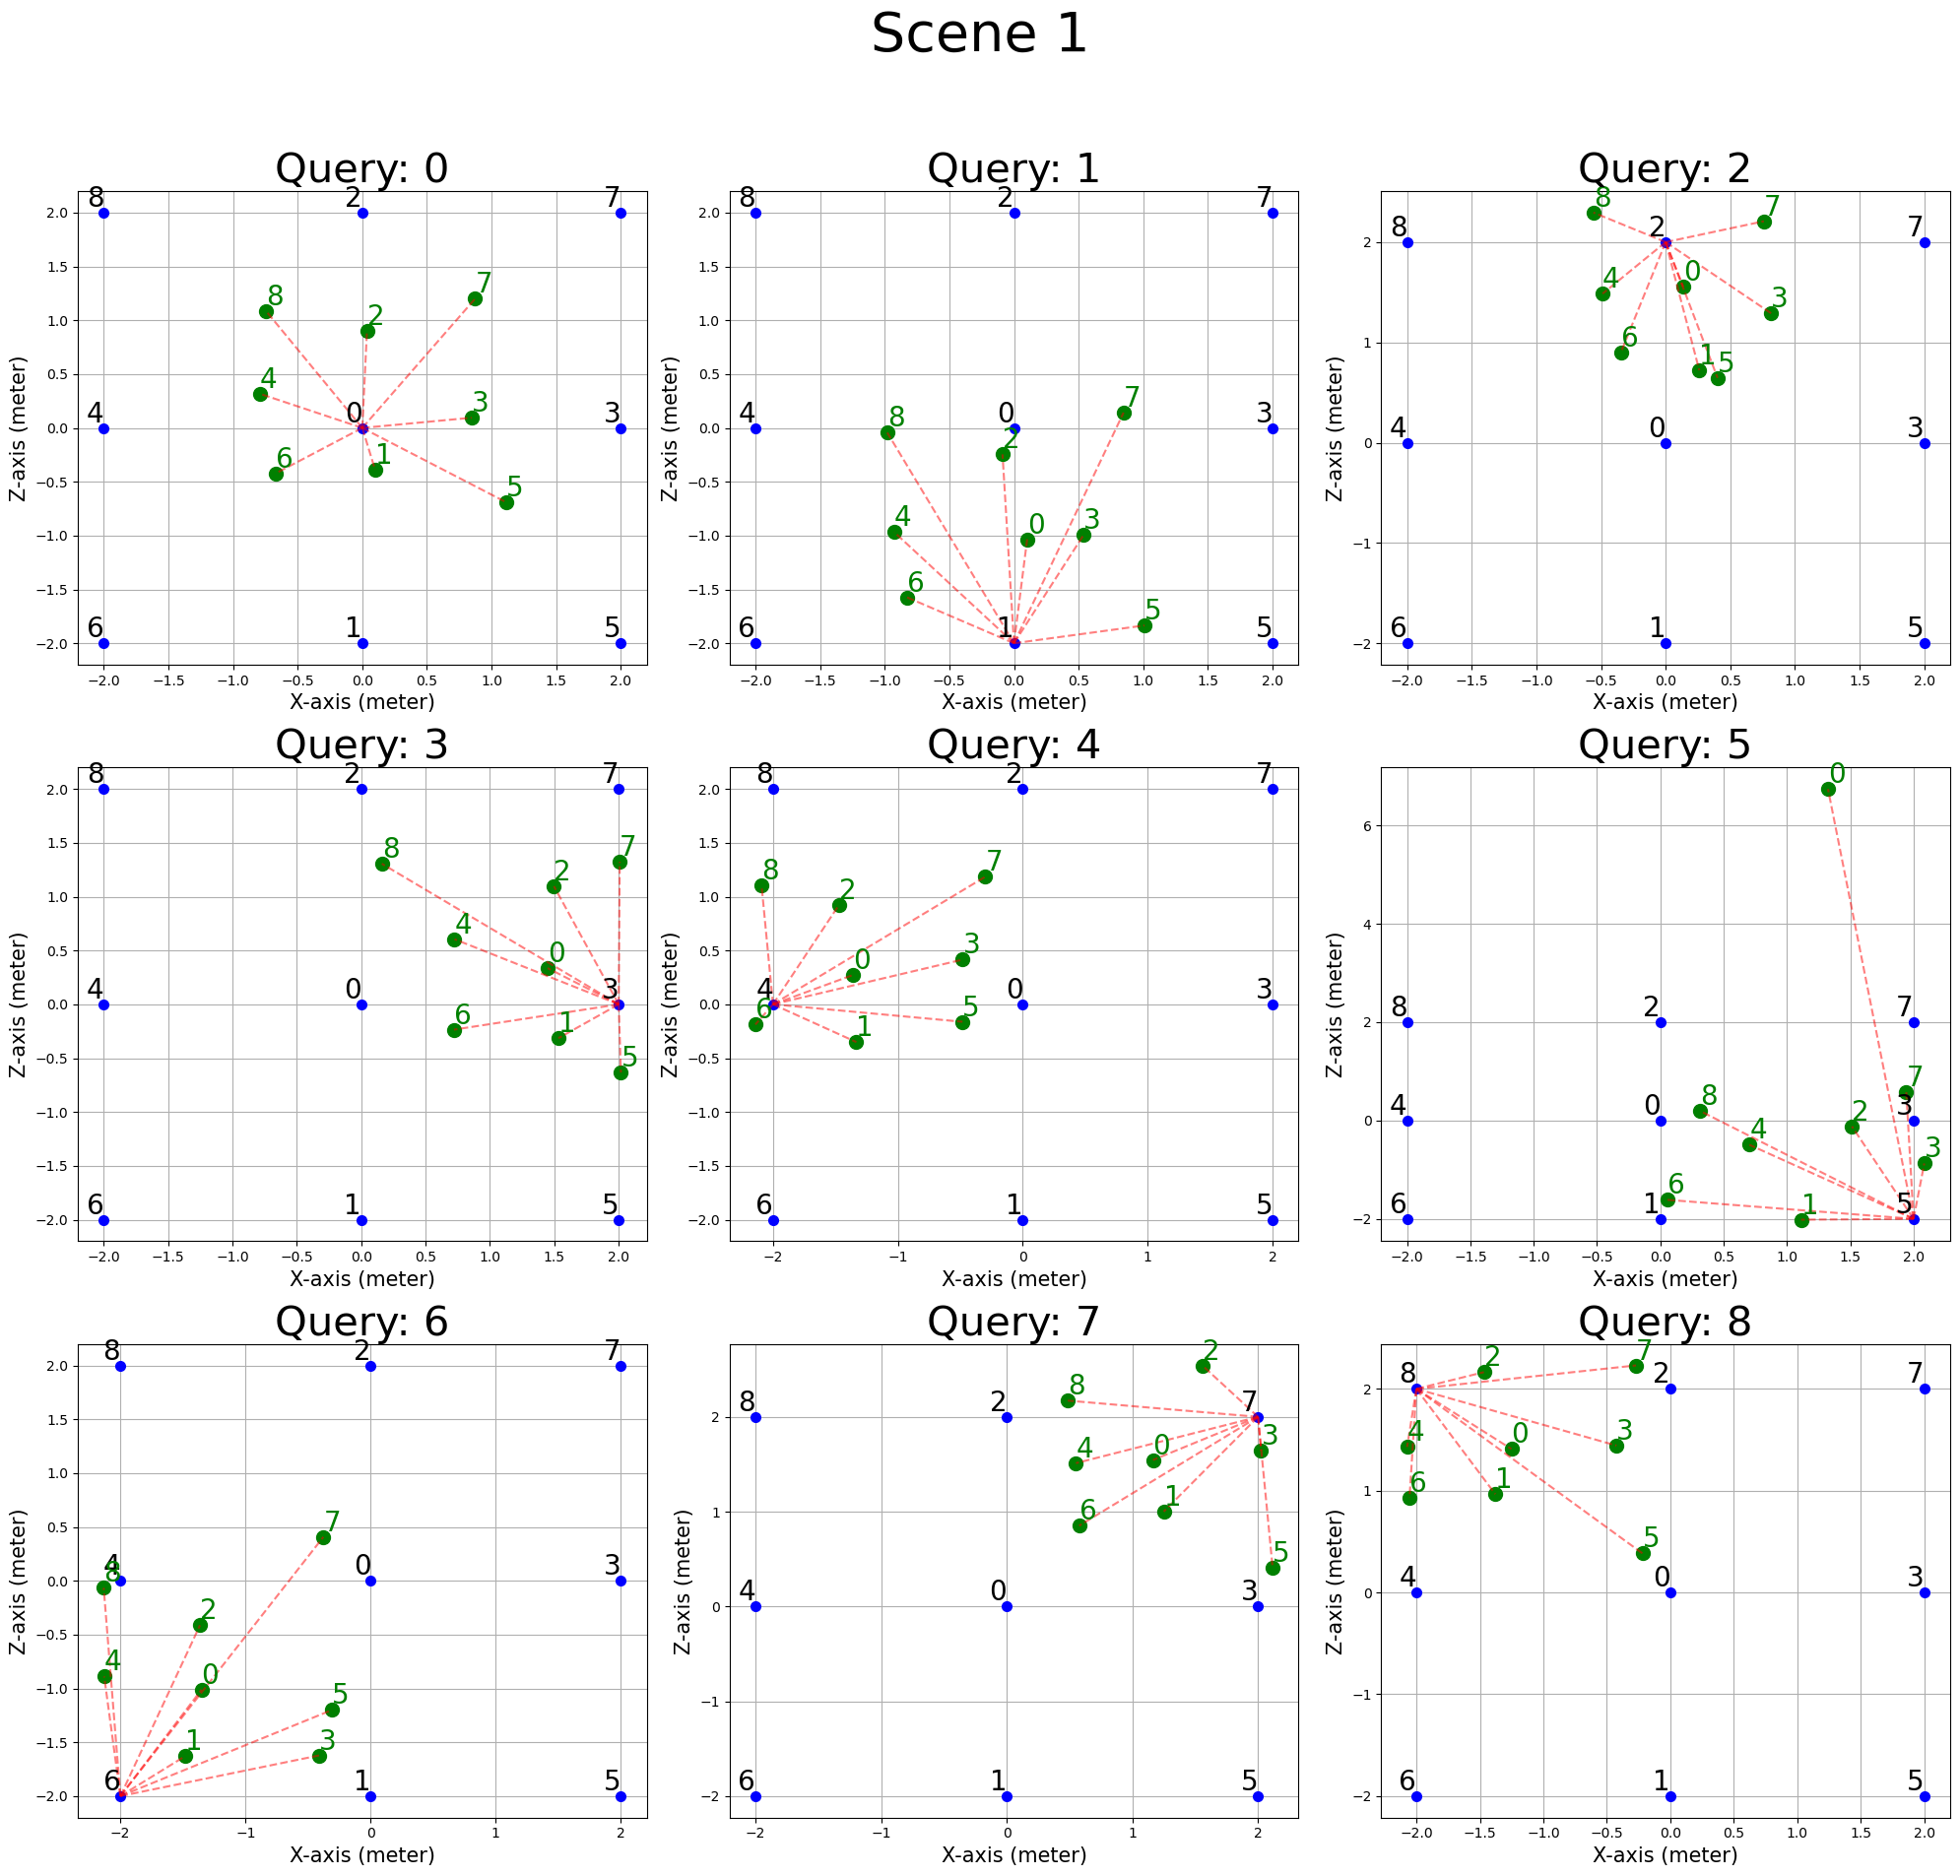

In [15]:


def create_combined_plot(scene_locations, set_images, corrected_data, scene_number):
    XY = len(set_images)
    n_rows = 3
    n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    fig.suptitle(f'Scene {scene_number}', fontsize=40)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for xy in range(XY):
        ax = axes[xy]
        query = xy
        if xy < XY:
            # Plot original scene locations
            for i, location in enumerate(scene_locations):
                ax.plot(location[0]/100, location[1]/100, 'o', color='blue',markersize=7)
                ax.text(location[0]/100, location[1]/100, str(i), color='black', fontsize=20, ha='right', va='bottom')
            
            
            for x in corrected_data:
                if x[1] == set_images[xy]:
                    anchor = np.where(set_images == x[0])[0][0]
                    new_location = [scene_locations[anchor][0]/100 + x[2][0], scene_locations[anchor][1]/100 + x[2][2]]
                    ax.plot(new_location[0], new_location[1], 'o', color='green',markersize=10)
                    ax.text(new_location[0], new_location[1], f'{anchor}', color='green', fontsize=20, ha='left', va='bottom')
                    ax.plot([scene_locations[query][0]/100, new_location[0]], 
                            [scene_locations[query][1]/100, new_location[1]], 'r--', alpha=0.5)
            
            ax.set_xlabel('X-axis (meter)', fontsize=15)
            ax.set_ylabel('Z-axis (meter)', fontsize=15)
            ax.set_title(f'Query: {query}', fontsize=30)
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

# Call the function with your specific data
# corrected_data = np.load('results/scene5.npy', allow_pickle=True)
create_combined_plot(scene_locations, set1, corrected_data, 1)


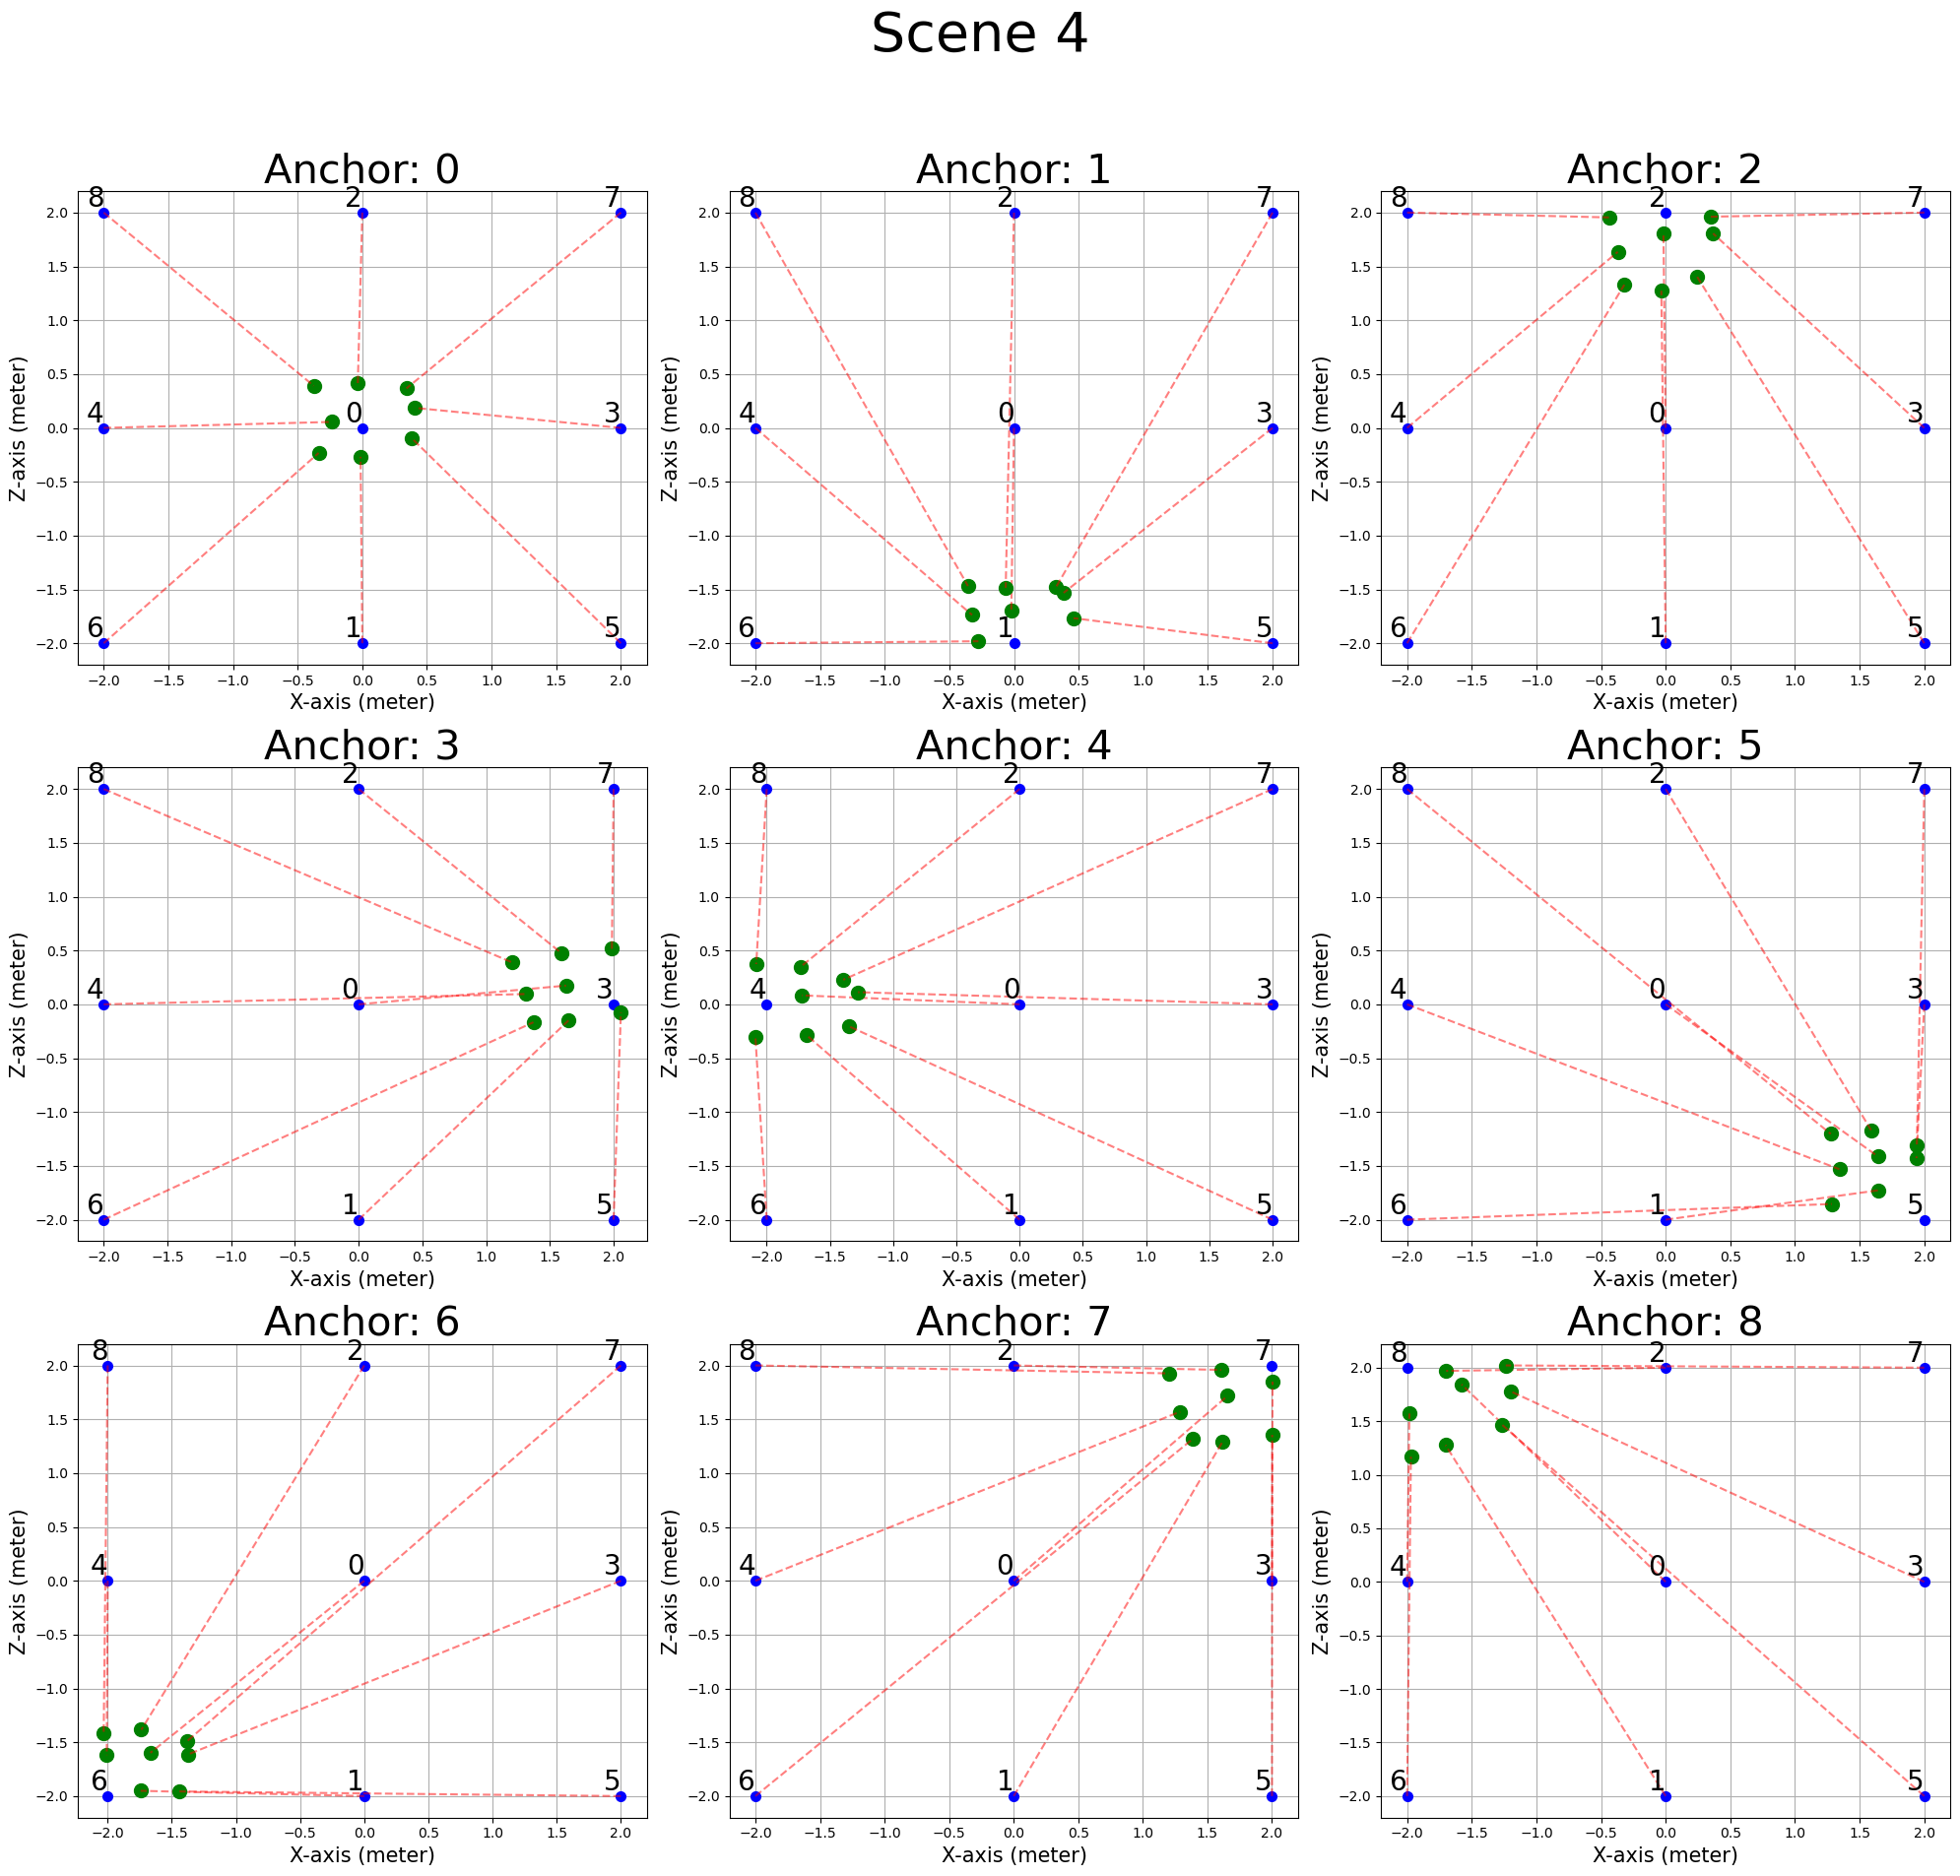

In [45]:
def create_combined_plot(scene_locations, set_images, corrected_data, scene_number):
    XY = len(set_images)
    n_rows = 3
    n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    fig.suptitle(f'Scene {scene_number}', fontsize=40)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for xy in range(XY):
        ax = axes[xy]
        anchor = xy
        if xy < XY:
            # Plot original scene locations
            for i, location in enumerate(scene_locations):
                ax.plot(location[0]/100, location[1]/100, 'o', color='blue',markersize=7)
                ax.text(location[0]/100, location[1]/100, str(i), color='black', fontsize=20, ha='right', va='bottom')
            
            
            for x in corrected_data:
                if x[0] == set_images[xy]:
                    query = np.where(set_images == x[1])[0][0]
                    new_location = [scene_locations[anchor][0]/100 + x[2][0], scene_locations[anchor][1]/100 + x[2][2]]
                    ax.plot(new_location[0], new_location[1], 'o', color='green',markersize=10)
                    # ax.text(new_location[0], new_location[1], f'{anchor}->{query}', color='green', fontsize=20, ha='left', va='bottom')
                    ax.plot([scene_locations[query][0]/100, new_location[0]], 
                            [scene_locations[query][1]/100, new_location[1]], 'r--', alpha=0.5)
            
            ax.set_xlabel('X-axis (meter)', fontsize=15)
            ax.set_ylabel('Z-axis (meter)', fontsize=15)
            ax.set_title(f'Anchor: {anchor}', fontsize=30)
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

# Call the function with your specific data
corrected_data = np.load('results/scene4.npy', allow_pickle=True)
create_combined_plot(scene_locations1, set4, corrected_data, 4)


In [29]:


def calculate_average_errors(scene_locations, set_images,corrected_data):
    total_error = 0
    horizontal_error = 0
    vertical_error = 0
    error_count = 0
    
    # Loop through each entry in the corrected data
    for x in corrected_data:
        # Find the corresponding scene location
        anchor = np.where(set_images == x[0])[0][0]  # The anchor image ID
        query = np.where(set_images == x[1])[0][0]  # Find corresponding query image ID
        true_location = scene_locations[query]
        
        # Calculate the corrected location
        new_location = [scene_locations[anchor][0]/ 100 + x[2][0], scene_locations[anchor][1]/ 100 + x[2][2]]
        
        # Calculate errors
        horizontal_error_val = abs(true_location[0]/ 100 - new_location[0]) 
        vertical_error_val = abs(true_location[1]/ 100 - new_location[1]) 
        total_error_val = np.sqrt(horizontal_error_val**2 + vertical_error_val**2)
        
        # Accumulate errors
        horizontal_error += horizontal_error_val
        vertical_error += vertical_error_val
        total_error += total_error_val
        error_count += 1

    # Calculate average errors
    avg_total_error = total_error / error_count if error_count > 0 else 0
    avg_horizontal_error = horizontal_error / error_count if error_count > 0 else 0
    avg_vertical_error = vertical_error / error_count if error_count > 0 else 0

    # Return the average errors
    return avg_total_error, avg_horizontal_error, avg_vertical_error

# Load corrected data from file
corrected_data = np.load('results/scene5.npy', allow_pickle=True)


# Calculate average errors
avg_total, avg_horizontal, avg_vertical = calculate_average_errors(scene_locations2, set5, corrected_data)

# Print the results
print(f"Average Total Error: {avg_total:.4f} meters")
print(f"Average Horizontal Error: {avg_horizontal:.4f} meters")
print(f"Average Vertical Error: {avg_vertical:.4f} meters")
print(f"{avg_total:.4f} & {avg_horizontal:.4f} & {avg_vertical:.4f} ")


Average Total Error: 2.0995 meters
Average Horizontal Error: 1.2997 meters
Average Vertical Error: 1.3281 meters
2.0995 & 1.2997 & 1.3281 


In [22]:
print(scene_locations1)

[[0, 0], [0, -200], [0, 200], [200, 0], [-200, 0], [200, -200], [-200, -200], [200, 200], [-200, 200]]
